# Fun with elementary gates for quantum computation

In reference [1] it was shown that a set of gates that consists of all one-bit quantum gates and the two-bit exclusive-or gate is universal in the sense that all unitary operations on arbitrary many bits can be expressed as compositions of these gates.  
In this notebook we are interested in constructing a gate V such that $V^{2}$=X (NOT) gate. Thanks to Lemma 4.3 from the reference [1] V gate can be easily expressed in terms of elementary gates. A cool thing about this is, if we have V gate, we can follow Lemma 6.1 from the same reference and construct a Toffoli gate.  
We will now show how to bring these interesting efforts to fruition.

[1] https://arxiv.org/abs/quant-ph/9503016

## Import needed libraries

In [1]:
%matplotlib inline
from qiskit import QuantumRegister, ClassicalRegister
# Importing standard Qiskit libraries and configuring account
from qiskit import QuantumCircuit, execute, Aer, IBMQ
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *
# Loading your IBM Q account(s)
provider = IBMQ.load_account()

Here we define a function that returns counts for ploting histogram of the measurement results. The input for the function is the backend type, for example 'qasm_simulator'.

In [8]:
from qiskit.tools.visualization import plot_histogram

def get_counts(back_end):
    ## First, simulate the circuit
    simulator = Aer.get_backend(back_end)
    job = execute(circuit, backend=simulator, shots=1000000)
    result = job.result()
    
    ## Then, plot a histogram of the results
    counts = result.get_counts(circuit)
    return counts

## $V^{2}$ = X (NOT gate)

Our constraint is that $V^{2}$ = X (NOT gate).  
According to Lemma 4.1 from [1] every unitary 2 x 2 matrix can be expressed as

$$
\begin{pmatrix}
e^{i\delta} & 0\\
0 & e^{i\delta}
\end{pmatrix}.
\begin{pmatrix}
e^{i\alpha/2} & 0\\
0 & e^{-i\alpha/2}
\end{pmatrix}.
\begin{pmatrix}
cos(\theta/2) & sin(\theta/2)\\
-sin(\theta/2) & cos(\theta/2)
\end{pmatrix}.
\begin{pmatrix}
e^{i\beta/2} & 0\\
0 & e^{-i\beta/2}
\end{pmatrix}
$$  
Since $$X = \begin{pmatrix} 0 & 1\\ 1 & 0 \end{pmatrix}$$ is an unitary matrix and we demand that $V^{2}$ = X, it is easy to see that $\alpha = -\beta = -\pi/2$, $\delta=\pi/4$, and $\theta=\pi/2$. This means that $$V =
\begin{pmatrix}
e^{i\pi/4} & 0\\
0 & e^{i\pi/4}
\end{pmatrix}.
\begin{pmatrix}
e^{-i\pi/4} & 0\\
0 & e^{i\pi/4}
\end{pmatrix}.
\begin{pmatrix}
cos(\pi/4) & sin(\pi/4)\\
-sin(\pi/4) & cos(\pi/4)
\end{pmatrix}.
\begin{pmatrix}
e^{i\pi/4} & 0\\
0 & e^{-i\pi/4}
\end{pmatrix} = 1/{\sqrt{2}}
\begin{pmatrix}
e^{i\pi/4} & e^{-i\pi/4}\\
e^{-i\pi/4} & e^{i\pi/4}
\end{pmatrix}
$$  

If we use the following notation
$$R_y(\theta) = \begin{pmatrix}cos(\theta/2) & sin(\theta/2)\\-sin(\theta/2) & cos(\theta/2)\end{pmatrix}$$
which is a rotation by ${\theta}$ around y axis,  
$$R_z(\alpha) = \begin{pmatrix}e^{i\alpha/2} & 0\\0 & e^{-i\alpha/2}\end{pmatrix},$$ a rotation by ${\alpha}$ around z axis, and 
$$Ph(\delta) = \begin{pmatrix}e^{i\delta} & 0\\0 & e^{i\delta}\end{pmatrix},$$ a phase shift with respect to ${\delta}$, we can express V as $$V = Ph(\pi/4)R_z(-\pi/2)R_y(\pi/2)R_z(\pi/2).$$  
According to Lemma 4.3 from [1] for any special unitary matrix W (i.e., with unity determinant and W is member of SU(2)), there exists matrices A, B, and C in SU(2) such that $$ABC = I$$ and $$AXBXC = W.$$
In our case $$W = R_z(-\pi/2)R_y(\pi/2)R_z(\pi/2)$$
and $$A = R_z(-\pi/2)R_y(\pi/4)$$
$$B = R_y(-\pi/4)R_z(0)=R_y(-\pi/4)$$
and $$C = R_z(\pi/2).$$
Knowing these 3 matrices is very important since we can use them to make a __control V__ gate according to Lemma 5.1 from the same [1] reference. We will now show how to do that.

## Control V gate

Our V gate contains a phase gate so we need first to show how to implement the phase gate. It is easy to check that the following matrix product results in the phase gate.

$$
\begin{pmatrix}
1 & 0\\
0 & e^{i\delta}
\end{pmatrix}.
\begin{pmatrix}
0 & 1\\
1 & 0
\end{pmatrix}.
\begin{pmatrix}
1 & 0\\
0 & e^{i\delta}
\end{pmatrix}.
\begin{pmatrix}
0 & 1\\
1 & 0
\end{pmatrix} = 
\begin{pmatrix}
0 & 1\\
e^{i\delta} & 0
\end{pmatrix}.
\begin{pmatrix}
0 & 1\\
e^{i\delta} & 0
\end{pmatrix} = 
\begin{pmatrix}
e^{i\delta} & 0\\
0 & e^{i\delta}
\end{pmatrix}
$$

This means that the phase gate can be implemented as 
$$Ph(\delta) = U_1(\delta)XU_1(\delta)X.$$ where 
$$U_1(\delta) = \begin{pmatrix}
1 & 0\\
0 & e^{i\delta}
\end{pmatrix}.$$

The phase gate can be coded as the following python function that takes 3 parameters: a quantum circuit, an angle and a qubit.

In [ ]:
#define phase gate 
def Ph(circuit, theta, qubit):
    circuit.x(qubit)
    circuit.u1(theta, qubit)
    circuit.x(qubit)
    circuit.u1(theta, qubit)

We can also implement it as an instruction as in the code snippet below.

In [ ]:
#define phase gate as an instruction
#delta  is a global variable defined outside the gate
qc_ph = QuantumCircuit(1, name='Ph')
qc_ph.x(0)
qc_ph.u1(delta, 0)
qc_ph.x(0)
qc_ph.u1(delta, 0)
Ph = qc_ph.to_instruction()

Essentially control V gate is implemented as the following circuit.

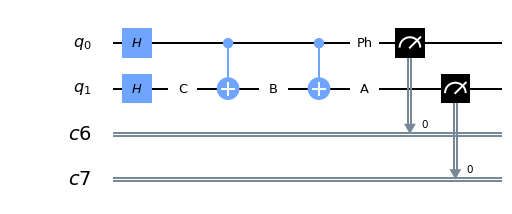

In [9]:
#define some constants
pi = 3.14159
delta = pi/4

#define A gate as an instruction
qc_A = QuantumCircuit(1, name='A')
qc_A.ry(pi/4, 0)
qc_A.rz(-pi/2, 0)
A = qc_A.to_instruction()

#define B gate as an instruction
qc_B = QuantumCircuit(1, name='B')
qc_B.ry(-pi/4, 0)
B = qc_B.to_instruction()

#define C gate as an instruction
qc_C = QuantumCircuit(1, name='C')
qc_C.rz(pi/2, 0)
C = qc_C.to_instruction()

#define phase gate as an instruction
qc_ph = QuantumCircuit(1, name='Ph')
qc_ph.x(0)
qc_ph.u1(delta, 0)
qc_ph.x(0)
qc_ph.u1(delta, 0)
Ph = qc_ph.to_instruction()

#now assemble respective quantum circuit
## Define a 2-qubit quantum circuit
q = QuantumRegister(2, 'q')
circuit = QuantumCircuit(q)
## We need also 4 classical registers
c = [ ClassicalRegister(1) for _ in range(2) ]
circuit = QuantumCircuit(q)
for register in c:
    circuit.add_register(register)

#initial state of an equal superposition of |0> and |1> states 
#so that we have all possible inputs of 2 qubits
circuit.h(q[0])
circuit.h(q[1])

circuit.append(C,[1])    # C gate acting on q[1]
circuit.cnot(q[0], q[1]) # CNOT between q[0] and q[1]
circuit.append(B, [1])   # B gate acting on q[1]
circuit.cnot(q[0], q[1]) # CNOT between q[0] and q[1]
circuit.append(A, [1])   # A gate acting on q[1]
circuit.append(Ph, [0])  # phase gate acting on q[0] (it really does not matter which qubit we pick)

#finish with measurements
circuit.measure(q[0], c[0])
circuit.measure(q[1], c[1])

## Draw the circuit
%matplotlib inline
circuit.draw(output="mpl")

There are 4 possible, equally probable, outputs: 00, 01, 10, or 11 with 1/4 probability.

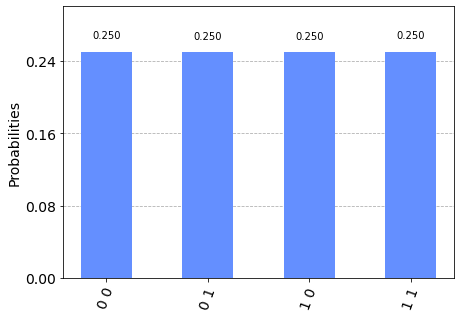

In [10]:
plot_histogram(get_counts('qasm_simulator'))

## Math part

To understand why we are getting these outputs we need to work out respective math.   
Our input state to the control V gate is a state of an equal superposition of 2 qubits.   
We start with 2 qubits in 0 state and apply Hadammard gate to each qubit resulting in 

$$\Psi_i=H|0>H|0>=1/\sqrt{2}(|0>+|1>)1/\sqrt{2}(|0>+|1>)=1/2(|00>+|01>+|10>+|11>).$$  

It is not difficult to see that the following are matrix representations of A, B, and C gates.

$$A = \begin{pmatrix} e^{-i\pi/4}cos(\pi/8) & e^{-i\pi/4}sin(\pi/8)\\ -e^{i\pi/4}sin(\pi/8) & e^{i\pi/4}cos(\pi/8) \end{pmatrix}$$

$$B = \begin{pmatrix} cos(\pi/8) & -sin(\pi/8)\\ sin(\pi/8) & cos(\pi/8) \end{pmatrix}$$

$$C = \begin{pmatrix} e^{i\pi/4} & 0\\ 0 & e^{-i\pi/4} \end{pmatrix}$$

Having this information we can easily deduce how these gates act on |0> and |1> qubit states.

$$A|0> = e^{-i\pi/4}cos(\pi/8)|0>-e^{i\pi/4}sin(\pi/8)|1>$$
$$A|1> = e^{-i\pi/4}sin(\pi/8)|0>+e^{i\pi/4}cos(\pi/8)|1>$$
$$B|0> = cos(\pi/8)|0>+sin(\pi/8)|1>$$
$$B|1> = -sin(\pi/8)|0>+cos(\pi/8)|1>$$
$$C|0>=e^{i\pi/4}|0>$$
$$C|1>=e^{-i\pi/4}|1>.$$
Now, we can analyze the circuit. After the C gate, the state of 2 qubits is 

$$\Psi_c=1/2(e^{i\pi/4}|00> + e^{-i\pi/4}|01>+e^{i\pi/4}|10>+e^{-i\pi/4}|11>).$$

Then comes the first CNOT gate which flips the second qubit state only if the first qubit is in |1> state resulting in 

$$\Psi_{x1}=1/2(e^{i\pi/4}|00> + e^{-i\pi/4}|01>+e^{i\pi/4}|11>+e^{-i\pi/4}|10>).$$

After the B gate, the state is 

$$\Psi_b=1/2[e^{i\pi/4}|0>(cos(\pi/8)|0>+sin(\pi/8)|1>)+\\
             e^{-i\pi/4}|0>(-sin(\pi/8)|0>+cos(\pi/8)|1>)+\\  
             e^{i\pi/4}|1>(-sin(\pi/8)|0>+cos(\pi/8)|1>)+\\
             e^{-i\pi/4}|1>(cos(\pi/8)|0>+sin(\pi/8)|1>)]$$
            
which simplifies to

$$\Psi_b=1/2[|00>(e^{i\pi/4}cos(\pi/8)-e^{-i\pi/4}sin(\pi/8))+\\ 
 |01>(e^{i\pi/4}sin(\pi/8)+e^{-i\pi/4}cos(\pi/8))+\\
 |10>(-e^{i\pi/4}sin(\pi/8)+e^{-i\pi/4}cos(\pi/8))+\\
 |11>(e^{i\pi/4}cos(\pi/8)+e^{-i\pi/4}sin(\pi/8))].
 $$

After the second CNOT gate, the 2 qubits state is 

$$\Psi_{x2}=1/2[|00>(e^{i\pi/4}cos(\pi/8)-e^{-i\pi/4}sin(\pi/8))+\\ 
 |01>(e^{i\pi/4}sin(\pi/8)+e^{-i\pi/4}cos(\pi/8))+\\
 |11>(-e^{i\pi/4}sin(\pi/8)+e^{-i\pi/4}cos(\pi/8))+\\
 |10>(e^{i\pi/4}cos(\pi/8)+e^{-i\pi/4}sin(\pi/8))].
 $$
 
 Finally comes the A gate resulting in 
 
 $$\Psi_a=1/2[|0>(e^{i\pi/4}cos(\pi/8)-e^{-i\pi/4}sin(\pi/8))(e^{-i\pi/4}cos(\pi/8)|0>-e^{i\pi/4}sin(\pi/8)|1>)+\\ 
 |0>(e^{i\pi/4}sin(\pi/8)+e^{-i\pi/4}cos(\pi/8))(e^{-i\pi/4}sin(\pi/8)|0>+e^{i\pi/4}cos(\pi/8)|1>)+\\
 |1>(-e^{i\pi/4}sin(\pi/8)+e^{-i\pi/4}cos(\pi/8))(e^{-i\pi/4}sin(\pi/8)|0>+e^{i\pi/4}cos(\pi/8)|1>)+\\
 |1>(e^{i\pi/4}cos(\pi/8)+e^{-i\pi/4}sin(\pi/8))(e^{-i\pi/4}cos(\pi/8)|0>-e^{i\pi/4}sin(\pi/8)|1>)]
 $$
 
 which simplifies to 
 
 $$\Psi_a=1/2[|00>+|01>+|10>(cos(\pi/4)+e^{-i\pi/2}sin(\pi/4))+|11>(cos(\pi/4)-e^{i\pi/2}sin(\pi/4))].$$
 
 We finish with the Phase gate which just adds a phase factor to $\Psi_a$ resulting in
 
 $$\Psi_{out}=e^{i\pi/4}/2[|00>+|01>+|10>(1-i)/{\sqrt{2}}+|11>(1-i)/{\sqrt{2}}].$$
 
 __As we can see our math confirms 4 possible, equally probable, outputs: 00, 01, 10, or 11 with 1/4 probability.__

## 2 times in a row __control__ V gate = CNOT

Now if we apply 2 times in a row __control__ V gate we should effectively have a __control__ X gate which is CNOT gate. The circuit below shows exactly that.

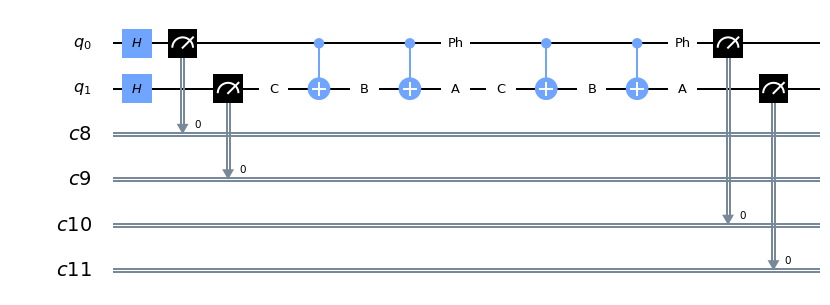

In [11]:
## Define a 2-qubit quantum circuit
q = QuantumRegister(2, 'q')
circuit = QuantumCircuit(q)
## We need also 4 classical registers
c = [ ClassicalRegister(1) for _ in range(4) ]
circuit = QuantumCircuit(q)
for register in c:
    circuit.add_register(register)

#initial state of an equal superposition of |0> and |1> states 
#so that we have all possible inputs of 2 qubits
circuit.h(q[0])
circuit.h(q[1])

circuit.measure(q[0], c[0])
circuit.measure(q[1], c[1])

circuit.append(C,[1])    # C gate acting on q[1]
circuit.cnot(q[0], q[1]) # CNOT between q[0] and q[1]
circuit.append(B, [1])   # B gate acting on q[1]
circuit.cnot(q[0], q[1]) # CNOT between q[0] and q[1]
circuit.append(A, [1])   # A gate acting on q[1]
circuit.append(Ph, [0])  # phase gate acting on q[0] (it really does not matter which qubit we pick)

circuit.append(C,[1])    # C gate acting on q[1]
circuit.cnot(q[0], q[1]) # CNOT between q[0] and q[1]
circuit.append(B, [1])   # B gate acting on q[1]
circuit.cnot(q[0], q[1]) # CNOT between q[0] and q[1]
circuit.append(A, [1])   # A gate acting on q[1]
circuit.append(Ph, [0])  # phase gate acting on q[0] (it really does not matter which qubit we pick)

#finish with measurements
circuit.measure(q[0], c[2])
circuit.measure(q[1], c[3])

## Draw the circuit
%matplotlib inline
circuit.draw(output="mpl")

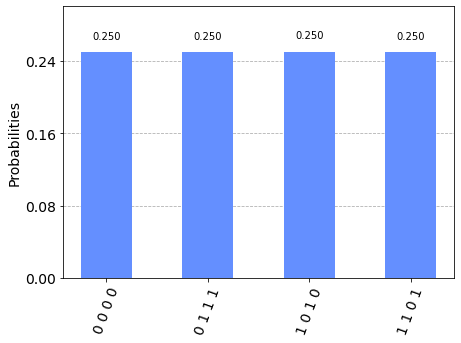

In [12]:
plot_histogram(get_counts('qasm_simulator'))

## 2 times in a row V gate = X

Using the expression for V gate 

$$V = Ph(\pi/4)R_z(-\pi/2)R_y(\pi/2)R_z(\pi/2)$$ 

we can now show when we apply twice in a row V gate we effectively get X gate.
For that purpose we define R gate as 

$$R=R_z(-\pi/2)R_y(\pi/2)R_z(\pi/2)$$ 

so essentially V gate in the circuit will be recognized as 

$$Ph(\pi/4)R.$$

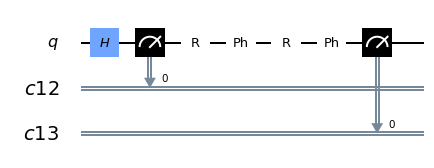

In [13]:
#define R gate as an instruction that contains only rotations
qc_R = QuantumCircuit(1, name='R')
qc_R.rz(pi/2, 0)
qc_R.ry(pi/2, 0)
qc_R.rz(-pi/2, 0)
R = qc_R.to_instruction()

#now assemble respective quantum circuit
## Define a 1-qubit quantum circuit
q = QuantumRegister(1, 'q')
circuit = QuantumCircuit(q)
## We need also 2 classical registers
c = [ ClassicalRegister(1) for _ in range(2) ]
circuit = QuantumCircuit(q)
for register in c:
    circuit.add_register(register)

#initial state of an equal superposition of |0> and |1> states 
#so that we have all possible inputs of 1 qubit
circuit.h(q[0])
circuit.measure(q[0], c[0])

circuit.append(R,[0])    # R gate acting on q[0]
circuit.append(Ph, [0])  # phase gate acting on q[0]
circuit.append(R,[0])    # R gate acting on q[0]
circuit.append(Ph, [0])  # phase gate acting on q[0]

#finish with measurements
circuit.measure(q[0], c[1])

## Draw the circuit
%matplotlib inline
circuit.draw(output="mpl")

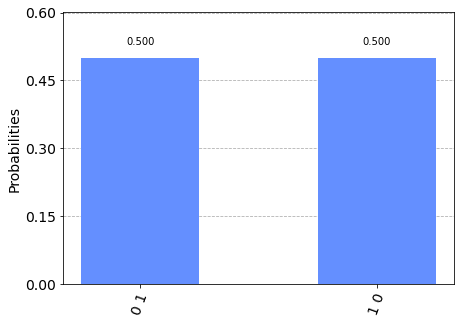

In [14]:
plot_histogram(get_counts('qasm_simulator'))

As expected the input |0> state is changed to |1> and vice versa.

## $V^{+}$ gate

Now, let's define $V^{+}$ gate. We start from the expression for V gate 

$$V= Ph(\pi/4)R_z(-\pi/2)R_y(\pi/2)R_z(\pi/2)$$ 

and apply Hermitian conjugation to it. We obtain

$$V^{+}=R_z(-\pi/2)R_y(-\pi/2)R_z(\pi/2)Ph(-\pi/4).$$ Obviously, $VV^{+}=V^{+}V=I.$ The circuit below shows exactly that identity.

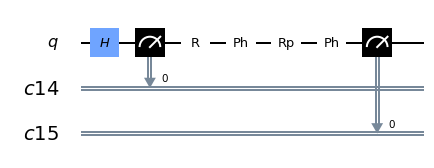

In [15]:
#define Rp gate as an instruction that contains only rotations
qc_Rp = QuantumCircuit(1, name='Rp')
qc_Rp.rz(pi/2, 0)
qc_Rp.ry(-pi/2, 0)
qc_Rp.rz(-pi/2, 0)
Rp = qc_Rp.to_instruction()

#now assemble respective quantum circuit
## Define a 1-qubit quantum circuit
q = QuantumRegister(1, 'q')
circuit = QuantumCircuit(q)
## We need also 2 classical registers
c = [ ClassicalRegister(1) for _ in range(2) ]
circuit = QuantumCircuit(q)
for register in c:
    circuit.add_register(register)

#initial state of an equal superposition of |0> and |1> states 
#so that we have all possible inputs of 1 qubit
circuit.h(q[0])
circuit.measure(q[0], c[0])

delta = pi/4
circuit.append(R,[0])     # R gate acting on q[0]
circuit.append(Ph, [0])   # phase gate acting on q[0]
delta = -pi/4
circuit.append(Rp,[0])    # R gate acting on q[0]
circuit.append(Ph, [0])   # phase gate acting on q[0]

#finish with measurements
circuit.measure(q[0], c[1])

## Draw the circuit
%matplotlib inline
circuit.draw(output="mpl")

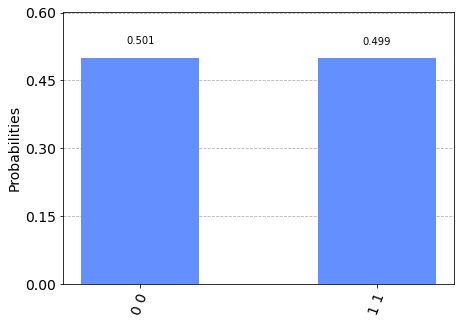

In [16]:
plot_histogram(get_counts('qasm_simulator'))

## __control__ $V^{+}$ gate

Let's constuct a circuit with __control__ $V^{+}$ gate. We need to Hermitian conjugate __control__ V gate.
So $$W^{+} = R_z(-\pi/2)R_y(-\pi/2)R_z(\pi/2)$$
$$A^{+} = R_y(-\pi/4)R_z(\pi/2)$$
$$B^{+} = R_y(\pi/4)$$
$$C^{+} = R_z(-\pi/2).$$
$$C^{+}B^{+}A^{+} = I$$
and $$C^{+}XB^{+}XA^{+} = W^{+}.$$

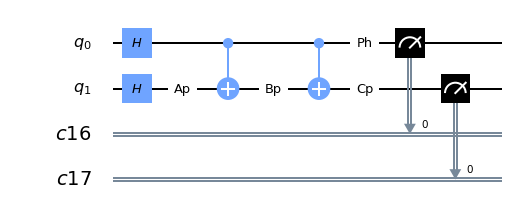

In [17]:
#define Ap gate as an instruction
qc_Ap = QuantumCircuit(1, name='Ap')
qc_Ap.rz(pi/2, 0)
qc_Ap.ry(-pi/4, 0)
Ap = qc_Ap.to_instruction()

#define Bp gate as an instruction
qc_Bp = QuantumCircuit(1, name='Bp')
qc_Bp.ry(pi/4, 0)
Bp = qc_Bp.to_instruction()

#define Cp gate as an instruction
qc_Cp = QuantumCircuit(1, name='Cp')
qc_Cp.rz(-pi/2, 0)
Cp = qc_Cp.to_instruction()

#now assemble respective quantum circuit
## Define a 2-qubit quantum circuit
q = QuantumRegister(2, 'q')
circuit = QuantumCircuit(q)
## We need also 4 classical registers
c = [ ClassicalRegister(1) for _ in range(2) ]
circuit = QuantumCircuit(q)
for register in c:
    circuit.add_register(register)

#initial state of an equal superposition of |0> and |1> states 
#so that we have all possible inputs of 2 qubits
circuit.h(q[0])
circuit.h(q[1])

circuit.append(Ap,[1])    # C gate acting on q[1]
circuit.cnot(q[0], q[1]) # CNOT between q[0] and q[1]
circuit.append(Bp, [1])   # B gate acting on q[1]
circuit.cnot(q[0], q[1]) # CNOT between q[0] and q[1]
circuit.append(Cp, [1])   # A gate acting on q[1]
delta=-pi/4
circuit.append(Ph, [0])  # phase gate acting on q[0] (it really does not matter which qubit we pick)

#finish with measurements
circuit.measure(q[0], c[0])
circuit.measure(q[1], c[1])

## Draw the circuit
%matplotlib inline
circuit.draw(output="mpl")

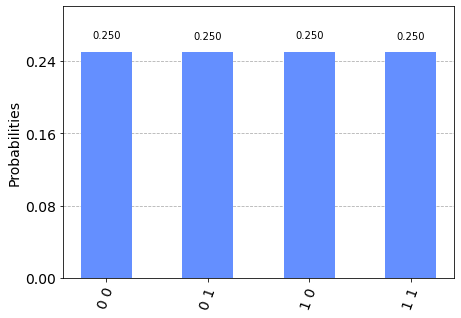

In [18]:
plot_histogram(get_counts('qasm_simulator'))

## (__control__ $V$)(__control__ $V^{+}$) = I

If we apply together __control__ V and __control__ $V^{+}$ gates we should get identity gate as the circuit below shows.

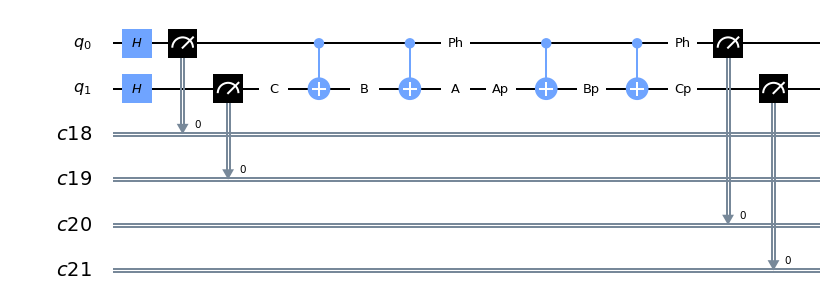

In [19]:
#now assemble respective quantum circuit
## Define a 2-qubit quantum circuit
q = QuantumRegister(2, 'q')
circuit = QuantumCircuit(q)
## We need also 4 classical registers
c = [ ClassicalRegister(1) for _ in range(4) ]
circuit = QuantumCircuit(q)
for register in c:
    circuit.add_register(register)

#initial state of an equal superposition of |0> and |1> states 
#so that we have all possible inputs of 2 qubits
circuit.h(q[0])
circuit.h(q[1])
circuit.measure(q[0], c[0])
circuit.measure(q[1], c[1])

circuit.append(C,[1])    # C gate acting on q[1]
circuit.cnot(q[0], q[1]) # CNOT between q[0] and q[1]
circuit.append(B, [1])   # B gate acting on q[1]
circuit.cnot(q[0], q[1]) # CNOT between q[0] and q[1]
circuit.append(A, [1])   # A gate acting on q[1]
delta=pi/4
circuit.append(Ph, [0])  # phase gate acting on q[0] (it really does not matter which qubit we pick)

circuit.append(Ap,[1])    # C gate acting on q[1]
circuit.cnot(q[0], q[1]) # CNOT between q[0] and q[1]
circuit.append(Bp, [1])   # B gate acting on q[1]
circuit.cnot(q[0], q[1]) # CNOT between q[0] and q[1]
circuit.append(Cp, [1])   # A gate acting on q[1]
delta=-pi/4
circuit.append(Ph, [0])  # phase gate acting on q[0] (it really does not matter which qubit we pick)

#finish with measurements
circuit.measure(q[0], c[2])
circuit.measure(q[1], c[3])

## Draw the circuit
%matplotlib inline
circuit.draw(output="mpl")

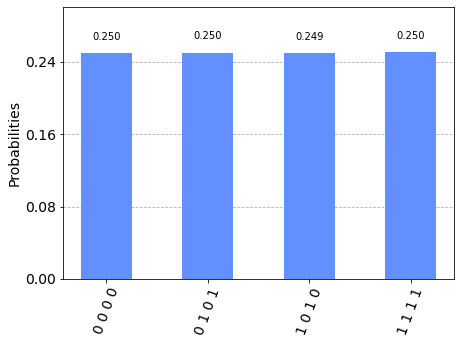

In [20]:
plot_histogram(get_counts('qasm_simulator'))

As expected qubits states do not change: 00->00, 10->10, 01->01, and 11->11.

## Toffoli gate
Now we can follow Lemma 6.1 from the reference [1] and construct a Toffoli gate.

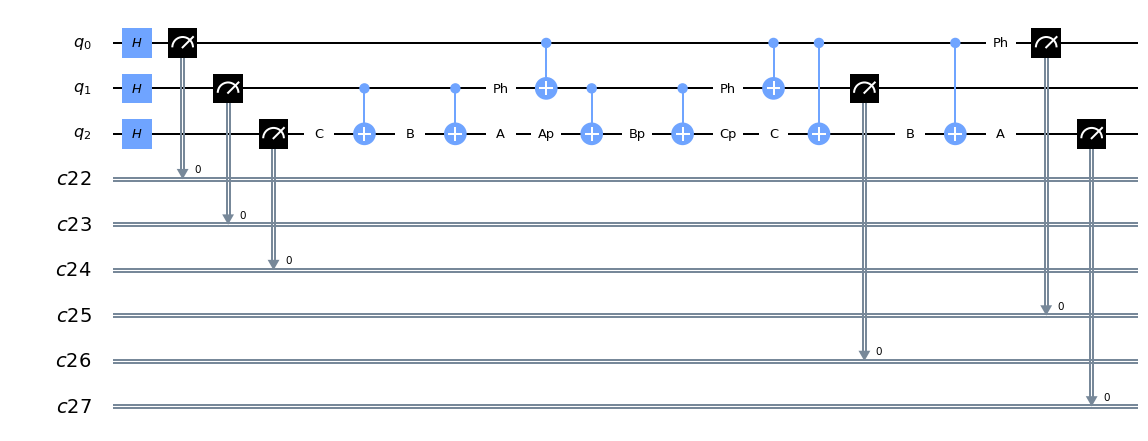

In [21]:
#now assemble respective quantum circuit
## Define a 3-qubit quantum circuit
q = QuantumRegister(3, 'q')
circuit = QuantumCircuit(q)
## We need also 3 classical registers
c = [ ClassicalRegister(1) for _ in range(6) ]
circuit = QuantumCircuit(q)
for register in c:
    circuit.add_register(register)
    
#initial state of an equal superposition of |0> and |1> states 
#so that we have all possible inputs of 3 qubits
circuit.h(q[0])
circuit.h(q[1])
circuit.h(q[2])
circuit.measure(q[0], c[0])
circuit.measure(q[1], c[1])
circuit.measure(q[2], c[2])

# control V gate between q[1] and q[2]
circuit.append(C,[2])    # C gate acting on q[2]
circuit.cnot(q[1], q[2]) # CNOT between q[1] and q[2]
circuit.append(B, [2])   # B gate acting on q[2]
circuit.cnot(q[1], q[2]) # CNOT between q[1] and q[2]
circuit.append(A, [2])    # A gate acting on q[2]
delta=pi/4
circuit.append(Ph, [1])  # phase gate acting on q[1]
                   
circuit.cnot(q[0], q[1]) # CNOT between q[0] and q[1]

# control V+ gate between q[1] and q[2]
circuit.append(Ap,[2])    # Ap gate acting on q[2]
circuit.cnot(q[1], q[2])  # CNOT between q[1] and q[2]
circuit.append(Bp, [2])   # Bp gate acting on q[2]
circuit.cnot(q[1], q[2])  # CNOT between q[1] and q[2]
circuit.append(Cp, [2])   # Cp gate acting on q[2]
delta=-pi/4
circuit.append(Ph, [1])  # phase gate acting on q[1]
                   
circuit.cnot(q[0], q[1]) # CNOT between q[0] and q[1]

# control V gate between q[0] and q[2]
circuit.append(C,[2])    # C gate acting on q[2]
circuit.cnot(q[0], q[2]) # CNOT between q[0] and q[2]
circuit.append(B, [2])   # B gate acting on q[2]
circuit.cnot(q[0], q[2]) # CNOT between q[0] and q[2]
circuit.append(A, [2])    # A gate acting on q[2]
delta=pi/4
circuit.append(Ph, [0])  # phase gate acting on q[0]

#finish with measurements
circuit.measure(q[0], c[3])
circuit.measure(q[1], c[4])
circuit.measure(q[2], c[5])

## Draw the circuit
%matplotlib inline
circuit.draw(output="mpl")

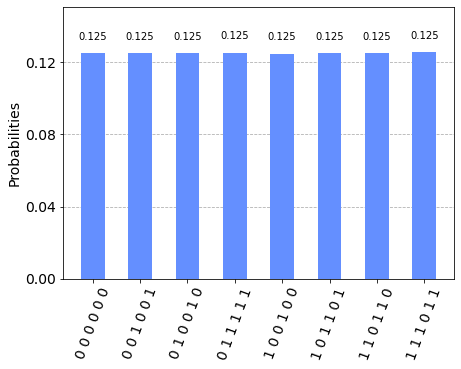

In [22]:
plot_histogram(get_counts('qasm_simulator'))

The Toffoli gate fips the q2 qubit state only when both q0 and q1 qubits are in the state |1>. The fourth bar corresponds to the case when the q2 qubit state is flipped from |1> to |0> and the eight bar corresponds to the case when the q2 qubit state is flipped from |0> to |1>.  
This is just one of many possible implementations of the Toffoli gate.   
For example, below is the implementation from the reference [2].

[2] https://arxiv.org/abs/1703.10793

## Implementing a Toffoli gate with 10 single-qubit gates and 6 CNOT gates

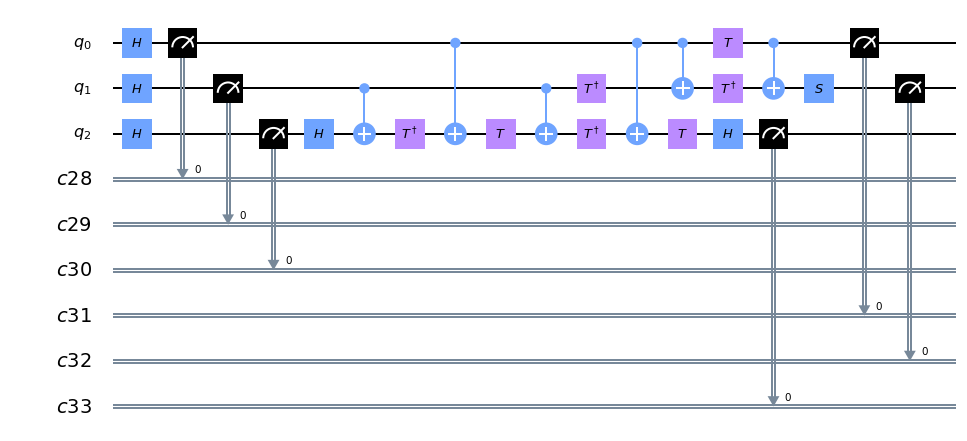

In [23]:
## Define a 3-qubit quantum circuit
q = QuantumRegister(3, 'q')
circuit = QuantumCircuit(q)
## We need also 6 classical registers
c = [ ClassicalRegister(1) for _ in range(6) ]
circuit = QuantumCircuit(q)
for register in c:
    circuit.add_register(register)

#initial state of an equal superposition of |0> and |1> states
circuit.h(q[0]) #Hadammard on q[0]
circuit.h(q[1]) #Hadammard on q[1]
circuit.h(q[2]) #Hadammard on q[2]

#measure q0, q1, and q2 before the Toffoli gate (to display the input values to the Toffoli gate)
circuit.measure(q[0], c[0])
circuit.measure(q[1], c[1])
circuit.measure(q[2], c[2])

circuit.h(q[2]) #Hadammard on q[2]
circuit.cx(q[1],q[2]) #CNOT between q1 and q2
circuit.tdg(q[2]) #Hermitian conjugate T gate on q[2]
circuit.cx(q[0],q[2]) #CNOT between q0 and q2
circuit.t(q[2]) #T gate on q[2]
circuit.cx(q[1],q[2]) #CNOT between q1 and q2
circuit.tdg(q[1]) #Hermitian conjugate T gate on q[1]
circuit.tdg(q[2]) #Hermitian conjugate T gate on q[2]
circuit.cx(q[0],q[2]) #CNOT between q0 and q2
circuit.cx(q[0],q[1]) #CNOT between q0 and q1
circuit.t(q[0]) #T gate on q[0]
circuit.tdg(q[1]) #Hermitian conjugate T gate on q[1]
circuit.t(q[2]) #T gate on q[2]
circuit.cx(q[0],q[1]) #CNOT between q0 and q1
circuit.s(q[1]) #T gate on q[1]
circuit.h(q[2]) #Hadammard on q[2]

## Finish off with the measurements
circuit.measure(q[0], c[3])
circuit.measure(q[1], c[4])
circuit.measure(q[2], c[5])

## Draw the circuit
%matplotlib inline
circuit.draw(output="mpl")

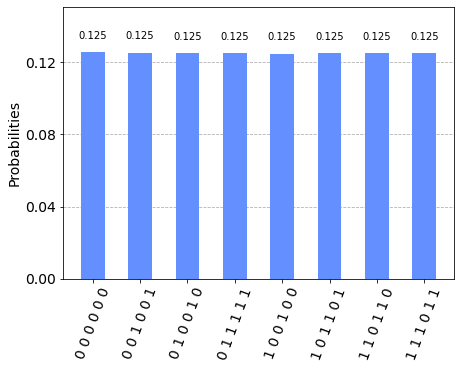

In [24]:
plot_histogram(get_counts('qasm_simulator'))

The circuit below does not change the states of q0 and q1 qubits!

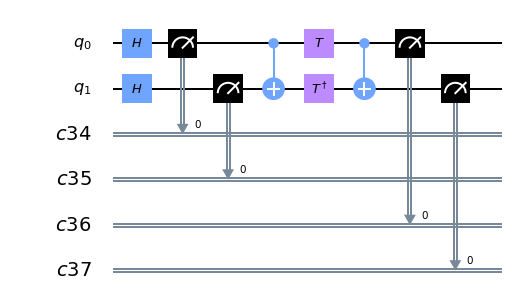

In [25]:
## Define a 2-qubit quantum circuit
q = QuantumRegister(2, 'q')
circuit = QuantumCircuit(q)
## We need also 4 classical registers
c = [ ClassicalRegister(1) for _ in range(4) ]
circuit = QuantumCircuit(q)
for register in c:
    circuit.add_register(register)

#initial state of an equal superposition of |0> and |1> states
circuit.h(q[0]) #Hadammard on q[0]
circuit.h(q[1]) #Hadammard on q[1]

#measure q0 and q1 before the swap gate (to display the input values to the swap gate)
circuit.measure(q[0], c[0])
circuit.measure(q[1], c[1])


circuit.cx(q[0],q[1]) #CNOT between q0 and q1 (q0 is a control qubit)
circuit.t(q[0])       #T gate on q[0]
circuit.tdg(q[1])     #Hermitian conjugate T gate on q[1]
circuit.cx(q[0],q[1]) #CNOT between q0 and q1 (q0 is a control qubit)

## Finish off with the measurements
circuit.measure(q[0], c[2])
circuit.measure(q[1], c[3])

## Draw the circuit
%matplotlib inline
circuit.draw(output="mpl")

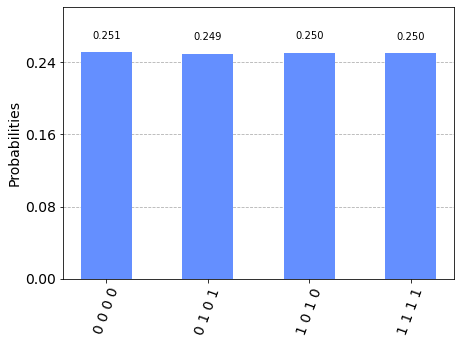

In [26]:
plot_histogram(get_counts('qasm_simulator'))

This information can be used to slightly simplify the above implementation of the Toffoli gate.
Respective circuit is displayed below.

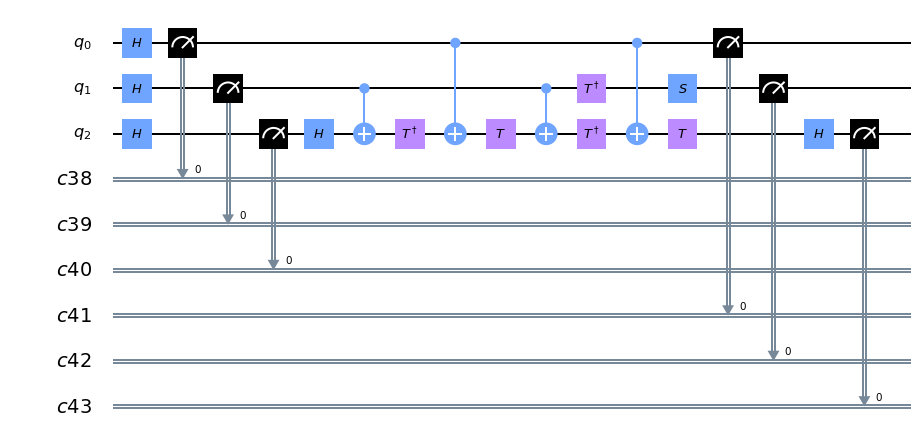

In [27]:
## Define a 3-qubit quantum circuit
q = QuantumRegister(3, 'q')
circuit = QuantumCircuit(q)
## We need also 6 classical registers
c = [ ClassicalRegister(1) for _ in range(6) ]
circuit = QuantumCircuit(q)
for register in c:
    circuit.add_register(register)

#initial state of an equal superposition of |0> and |1> states
circuit.h(q[0]) #Hadammard on q[0]
circuit.h(q[1]) #Hadammard on q[1]
circuit.h(q[2]) #Hadammard on q[2]

#measure q0, q1, and q2 before the Toffoli gate (to display the input values to the Toffoli gate)
circuit.measure(q[0], c[0])
circuit.measure(q[1], c[1])
circuit.measure(q[2], c[2])

circuit.h(q[2]) #Hadammard on q[2]
circuit.cx(q[1],q[2]) #CNOT between q1 and q2
circuit.tdg(q[2]) #Hermitian conjugate T gate on q[2]
circuit.cx(q[0],q[2]) #CNOT between q0 and q2
circuit.t(q[2]) #T gate on q[2]
circuit.cx(q[1],q[2]) #CNOT between q1 and q2
circuit.tdg(q[1]) #Hermitian conjugate T gate on q[1]
circuit.tdg(q[2]) #Hermitian conjugate T gate on q[2]
circuit.cx(q[0],q[2]) #CNOT between q0 and q2
#circuit.cx(q[0],q[1]) #CNOT between q0 and q1
#circuit.t(q[0]) #T gate on q[0]
#circuit.tdg(q[1]) #Hermitian conjugate T gate on q[1]
circuit.t(q[2]) #T gate on q[2]
#circuit.cx(q[0],q[1]) #CNOT between q0 and q1
circuit.s(q[1]) #T gate on q[1]
circuit.h(q[2]) #Hadammard on q[2]

## Finish off with the measurements
circuit.measure(q[0], c[3])
circuit.measure(q[1], c[4])
circuit.measure(q[2], c[5])

## Draw the circuit
%matplotlib inline
circuit.draw(output="mpl")

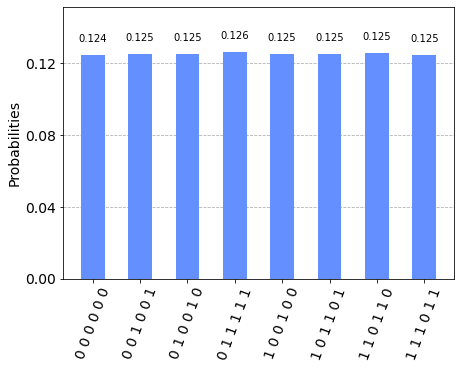

In [28]:
plot_histogram(get_counts('qasm_simulator'))

As we can see the Toffoli gate behavior is demonstrated. The q2 qubit state is flipped only when both q0 and q1 qubits are in the state |1>.